In [1]:
%matplotlib inline
import re
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd

In [2]:
import util
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import scale
from sklearn.neural_network import MLPClassifier

In [3]:
### ignore warnings caused by librosa 
import warnings
warnings.filterwarnings("ignore")

In [4]:
SAMPLE_RATE = 22050

In [5]:
T = 4.0    # seconds
t = np.linspace(0, T, int(T*SAMPLE_RATE), endpoint=False) # time variable
freq = 440
signal = np.sin(2*np.pi*freq*t)

In [5]:
train = np.load("data/train.npy")
X_train = train[:,1:]
y_train = train[:,0]
X_labeled = X_train[y_train != -1]
y_labeled = y_train[y_train != -1]
X_unlabeled = X_train[y_train == -1]
y_unlabeled = y_train[y_train == -1]
del train

test = np.load("data/test.npy")
X_test = test[:,1:]
del test

In [6]:
# save everything so your life stops ending every time kernel crashes
np.save("X_train.npy", X_train)
np.save("y_train.npy", y_train)
np.save("X_labeled.npy", X_labeled)
np.save("y_labeled.npy", y_labeled)
np.save("X_test.npy", X_test)

NameError: name 'X_train' is not defined

In [7]:
# Just some re-shaping and dimension finding
N = 6374
print("N:",N)
print("Train shape",X_train.shape)
N_train = X_train.shape[0]
NUM_SAMPLES = X_train.shape[1]-1

N: 6374


NameError: name 'X_train' is not defined

In [8]:
# JUST SOME FOURIER TRANSFORM PARAMETERS
BINS_OCTAVE = 12*2
N_OCTAVES = 7
NUM_BINS = BINS_OCTAVE * N_OCTAVES

In [9]:
# Given a wav time series, makes a mel spectrogram
# which is a short-time fourier transform with
# frequencies on the mel (log) scale.
def mel_spec(y):
    Q = librosa.cqt(y=y, sr=SAMPLE_RATE, bins_per_octave=BINS_OCTAVE,n_bins=NUM_BINS)
    Q_db = librosa.amplitude_to_db(Q,ref=np.max)
    return Q_db

In [10]:
# This means that the spectrograms are 168 rows (frequencies)
# By 173 columns (time frames)
song = X_train[0]
test_spec = mel_spec(song)
print(test_spec.shape)
FEATS = test_spec.shape[0]
FRAMES = test_spec.shape[1]

(168, 173)


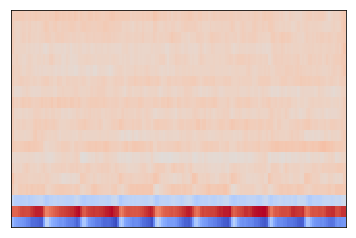

In [13]:
# librosa.display.specshow(tmp_train[2], y_axis='hz')
librosa.display.specshow(mfccs[17])#, y_axis='hz')

In [50]:
mfccs[17].shape

(20, 173)

In [12]:
signal = X_train[0]
librosa.feature.mfcc(signal).shape
mel_spec(signal).shape

(168, 173)

In [60]:
def get_feats(d):
    mfccs = []
    mels = []
    tempos = []
    tempograms = []
    for signal in d:
        mfcc = librosa.feature.mfcc(signal)
        mel = np.mean(mel_spec(signal), axis = 0)
        tempo = librosa.beat.tempo(signal)[0]
        tempogram = np.mean(librosa.beat.tempogram(signal), axis = 0)
        mfccs.append(mfcc)
        mels.append(mel)
        tempos.append(tempo)
        tempograms.append(tempograms)
    return mfccs, mels, tempos, tempograms

In [ ]:
contrasts = []
for signal in X_labeled:
    contrasts.append(librosa.feature.spectral_contrast(signal))

In [ ]:
contrasts = []
for signal in X_labeled:
    contrasts.append(librosa.feature.spectral_contrast(signal))
np.save("contrasts.npy", contrasts)
del contrasts
print("contrast done")

flatness = []
for signal in X_labeled:
    flatness.append(librosa.feature.spectral_flatness(signal))
np.save("flatnesses.npy", flatness)
del flatness
print("flatness done")

centroids = []
for signal in X_labeled:
    centroids.append(librosa.feature.spectral_centroid(signal))
np.save("centroids.npy", centroids)
del centroids
print("centroid done")

bandwidths = []
for signal in X_labeled:
    bandwidths.append(librosa.feature.spectral_bandwidth(signal))
np.save("bandwidths.npy", bandwidths)
del bandwidths
print("bandwidth done")

chroma = []
for signal in X_labeled:
    chroma.append(librosa.feature.chroma_cens(signal))
np.save("chromas.npy", chroma)
del chroma
print("chroma done")

contrast done
flatness done
centroid done
bandwidth done


In [ ]:
data = zip(X_labeled, y_labeled)

mfccs, mels, tempos, tempograms = get_feats(data)

# save your features otherwise you will be sad
np.save("mfccs.npy", mfccs)
np.save("mels.npy", mels)
np.save("tempos.npy", tempos)
np.save("tempograms.npy", tempograms)

In [10]:
X_labeled = np.load("X_labeled.npy")
y_labeled = np.load("y_labeled.npy")
data = zip(X_labeled, y_labeled)

In [11]:
mfccs = np.load("mfccs.npy")
mels = np.load("mels.npy")
tempos = np.load("tempos.npy")
tempograms = np.load("tempograms.npy")

In [12]:
X_train = np.load("X_train.npy")

In [9]:
feats = []
for i in range(len(tempos)):
    feat = np.concatenate((mfccs[i].flatten(), mels[i]))
    feats.append(feat)      

            

In [63]:
len(mfccs[i][3:].flatten())

2941

3634

In [10]:
scale0 = scale(feats)

In [52]:
scale2 = scale(feats2)

In [13]:
labels = np.load("y_labeled.npy")

In [54]:
params = {"n_neighbors": [1]}
gs = GridSearchCV(KNeighborsClassifier(), params, n_jobs=-1, scoring='accuracy', cv=4, verbose=3)
gs.fit(scale0, labels)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   11.5s finished


GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_neighbors': [1]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=3)

In [55]:
print(gs.best_params_), 
gs.best_score_

{'n_neighbors': 1}

0.6545296922410057

In [65]:
params = { }
gs = GridSearchCV(RandomForestClassifier(), params, n_jobs=-1, scoring='accuracy', cv=4, verbose=3)
gs.fit(scale0, labels)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    4.8s finished


GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=3)

In [66]:
print(gs.best_params_), 
gs.best_score_

{}

0.6376246207195492

In [11]:

params = {}
gs2 = GridSearchCV(KMeans(n_clusters=10,max_iter=5000), params, n_jobs=-1, scoring='accuracy', cv=4, verbose=3)
gs2.fit(scale0, labels)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   32.1s finished


GridSearchCV(cv=4, error_score='raise',
       estimator=KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=5000,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=3)

In [12]:
gs2.best_score_

0.09406155179887299

In [14]:
mfccs_trunc = mfccs[:,3:,:]
mfccs_trunc.shape
mfccs_trunc = mfccs_trunc.reshape((2307, 17*173))

In [19]:
rfc = RandomForestClassifier(n_estimators=200)
params = { }
gs3 = GridSearchCV(rfc, params, n_jobs=-1, scoring='accuracy', cv=4, verbose=3)
gs3.fit(scale(mfccs_trunc), labels)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  1.0min finished


GridSearchCV(cv=4, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=3)

In [20]:
gs3.best_score_

0.6419592544429996

In [20]:
N_labeled = X_labeled.shape[0]
X_labeled_train = np.zeros((N_labeled,FEATS,FRAMES))
for i in range(N_labeled):
    X_labeled_train[i,:,:] = mel_spec(X_labeled[i])

In [21]:
Xltz = X_labeled_train.copy()
# zero out bottom 
trunc_freq = 0
Xltz[:,:trunc_freq,:] = 0
Xltz = Xltz.reshape((Xltz.shape[0],Xltz.shape[1]*Xltz.shape[2]))

In [31]:
gbc = GradientBoostingClassifier(n_estimators=100)
rbc = RandomForestClassifier(n_estimators=200)
params = {}
gs = GridSearchCV(rbc, params, n_jobs=-1, scoring='accuracy', cv=8, verbose=3)
gs.fit(X_labeled_train.reshape((X_labeled_train.shape[0],X_labeled_train.shape[1]*X_labeled_train.shape[2])), y_labeled)

Fitting 8 folds for each of 1 candidates, totalling 8 fits
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ....................... , score=0.6438356164383562, total= 1.9min
[CV] ....................... , score=0.6095890410958904, total= 1.8min
[CV]  ................................................................
[CV] ....................... , score=0.5938566552901023, total= 1.9min
[CV]  ................................................................
[CV] ....................... , score=0.6061643835616438, total= 1.9min


[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min


[CV]  ................................................................
[CV]  ................................................................
[CV] ....................... , score=0.6140350877192983, total= 1.7min
[CV] ....................... , score=0.6097560975609756, total= 1.7min
[CV] ........................ , score=0.607773851590106, total= 1.6min
[CV] ....................... , score=0.6113074204946997, total= 1.6min


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  3.7min finished


GridSearchCV(cv=8, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=3)

In [32]:
gs2 = GridSearchCV(rbc, {'n_estimators': [50, 70, 100, 125, 150, 200]}, n_jobs=-1, scoring='accuracy', cv=8, verbose=3)
gs2.fit(X_labeled_train.
       reshape((X_labeled_train.shape[0],X_labeled_train.shape[1]*X_labeled_train.shape[2])), y_labeled)

Fitting 8 folds for each of 1 candidates, totalling 8 fits
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ....................... , score=0.5938566552901023, total= 1.4min
[CV]  ................................................................
[CV] ....................... , score=0.6027397260273972, total= 1.4min
[CV]  ................................................................
[CV] ....................... , score=0.6027397260273972, total= 1.4min
[CV]  ................................................................
[CV] ....................... , score=0.6027397260273972, total= 1.5min


[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:  1.6min remaining:  1.6min


[CV]  ................................................................
[CV] ....................... , score=0.6167247386759582, total= 2.6min
[CV] ........................ , score=0.607773851590106, total= 2.6min
[CV] ....................... , score=0.5929824561403508, total= 2.6min
[CV] ....................... , score=0.6007067137809188, total= 2.5min


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  4.2min finished


GridSearchCV(cv=8, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=3)

In [36]:
gs2.grid_scores_,

([mean: 0.60251, std: 0.00706, params: {}],)

In [30]:
del X_unlabeled
del y_unlabeled

In [41]:
del mfccs,mels,tempos,tempograms

In [111]:
 ipd.Audio(X_test[470], rate=SAMPLE_RATE)

In [14]:
flatnesses=np.load('flatnesses.npy')
contrasts=np.load('contrasts.npy')
chromas=np.load('chromas.npy')
centroids=np.load('centroids.npy')
bandwidths=np.load('bandwidths.npy')

In [46]:
print(mfccs.shape,mels.shape,flatnesses.shape, contrasts.shape, chromas.shape, centroids.shape, bandwidths.shape)

(2307, 20, 173) (2307, 173) (2307, 1, 173) (2307, 7, 173) (2307, 12, 173) (2307, 1, 173) (2307, 1, 173)


In [14]:
mfccs.shape

(2307, 20, 173)

In [16]:
feats_ham = []
for i in range(2307):
    feat = np.concatenate((mfccs[i].flatten(), 
                           mels[i],
                           contrasts[i].flatten(),
                           centroids[i].flatten()))
    feats_ham.append(feat)   
np.save('feats_ham.npy',feats_ham)

In [57]:
params={}
gs_ham = GridSearchCV(RandomForestClassifier(n_estimators=200), params, n_jobs=-1, scoring='accuracy', cv=4, verbose=3)
gs_ham.fit(feats_ham, labels)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   35.5s finished


GridSearchCV(cv=4, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=3)

In [17]:
params={}
gs_ham = GridSearchCV(GradientBoostingClassifier(learning_rate=0.01, n_estimators=80), params, n_jobs=-1, scoring='accuracy', cv=4, verbose=3)
gs_ham.fit(feats_ham, labels)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed: 40.9min finished


GridSearchCV(cv=4, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=80,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=3)

In [18]:
gs_ham.best_score_

0.6107498916341569

In [41]:
f_i=gs_ham.best_estimator_.feature_importances_
f_i

array([2.25740660e-04, 2.51052543e-04, 1.04243776e-04, ...,
       4.16664506e-05, 9.48958175e-05, 7.69669465e-05])

In [54]:
i_mfcc = np.mean(f_i[:20*173])
i_mels = np.mean(f_i[20*173:20*173+173])
i_flat = np.mean(f_i[20*173+173:20*173+173+173])
i_cont = np.mean(f_i[20*173+173+173 : 20*173+173+173+7*173])
i_chro = np.mean(f_i[20*173+173+173+7*173 : 20*173+173+173+7*173+12*173])
i_cent = np.mean(f_i[20*173+173+173+7*173+12*173 : 20*173+173+173+7*173+12*173+173])
i_band = np.mean(f_i[20*173+173+173+7*173+12*173+173 : 20*173+173+173+7*173+12*173+173+173])

print(i_mfcc,i_mels,i_flat,i_cont,i_chro,i_cent,i_band)

0.00013849151172696562 0.0005173069550800912 0.00010893751613869719 0.00014372205826781212 9.544532719652551e-05 0.0001475160947190967 8.535768609905999e-05


In [37]:
np.flipud(np.argsort(f_i))

array([3627, 3586, 3568, ..., 6318, 4140, 6724], dtype=int64)

In [ ]:
preds = gs_ham.best_estimator_.predict(X)
util.write_predictions(preds, range(len(preds)), "rf_basic.csv")

## predicting stuff

In [59]:
contrasts = []
for signal in X_test:
    contrasts.append(librosa.feature.spectral_contrast(signal))
np.save("contrasts_test.npy", contrasts)
del contrasts
print("contrast done")



centroids = []
for signal in X_test:
    centroids.append(librosa.feature.spectral_centroid(signal))
np.save("centroids_test.npy", centroids)
del centroids
print("centroid done")


contrast done
centroid done


In [61]:
def get_mfcc_mel(d):
    mfccs = []
    mels = []
    for signal in d:
        mfcc = librosa.feature.mfcc(signal)
        mel = np.mean(mel_spec(signal), axis = 0)
        mfccs.append(mfcc)
        mels.append(mel)
    return mfccs, mels

In [21]:


mfccs_test, mels_test = get_mfcc_mel(X_test)

# save your features otherwise you will be sad
# np.save("mfccs.npy", mfccs)
# np.save("mels.npy", mels)
# np.save("tempos.npy", tempos)
# np.save("tempograms.npy", tempograms)

NameError: name 'get_mfcc_mel' is not defined

In [71]:
np.save("mfccs_test.npy", mfccs_test)
np.save("mels_test.npy", mels_test)

In [24]:
mfccs_test = np.load('mfccs_test.npy')
mels_test = np.load('mels_test.npy')

In [25]:
contrasts_test = np.load('contrasts_test.npy')
centroids_test = np.load('centroids_test.npy')

feats_ham_test = []
for i in range(951):
    feat = np.concatenate((mfccs_test[i].flatten(), 
                           mels_test[i],
                           contrasts_test[i].flatten(),
                           centroids_test[i].flatten()))
    feats_ham_test.append(feat)  

In [75]:
preds = gs_ham.best_estimator_.predict(feats_ham_test)
util.write_predictions(preds, range(len(preds)), "rf_ham.csv")

In [26]:
preds = gs_ham.best_estimator_.predict(feats_ham_test)
util.write_predictions(preds, range(len(preds)), "gb_ham.csv")

In [73]:
X_test = np.load("X_test.npy")
test_feats = []

mfccs, mels, tempos, tempograms = get_feats(X_test)
for i in range(len(tempos)):
    feat = np.concatenate((np.array([tempos[i]]), mfccs[i].flatten(), mels[i]))
    test_feats.append(feat)      


In [74]:
preds = gs.best_estimator_.predict(test_feats)
# util.write_predictions(preds, range(len(preds)), "rfc, mfccflat, melmean, tempo, scaled.csv")

In [76]:
for x in preds:
    print x

2.0
2.0
5.0
2.0
5.0
2.0
2.0
3.0
2.0
5.0
2.0
5.0
2.0
5.0
2.0
5.0
5.0
5.0
5.0
9.0
2.0
5.0
5.0
5.0
5.0
0.0
5.0
2.0
3.0
3.0
5.0
5.0
5.0
2.0
5.0
0.0
2.0
3.0
2.0
5.0
5.0
5.0
5.0
5.0
9.0
5.0
3.0
2.0
5.0
5.0
2.0
5.0
5.0
3.0
5.0
3.0
2.0
5.0
5.0
2.0
5.0
5.0
5.0
5.0
5.0
5.0
3.0
2.0
0.0
5.0
2.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
2.0
5.0
5.0
2.0
5.0
5.0
3.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
0.0
5.0
2.0
5.0
5.0
5.0
3.0
5.0
3.0
2.0
5.0
2.0
2.0
0.0
2.0
5.0
2.0
5.0
2.0
2.0
0.0
3.0
5.0
5.0
2.0
5.0
0.0
5.0
5.0
5.0
5.0
3.0
5.0
0.0
5.0
2.0
2.0
0.0
5.0
5.0
2.0
5.0
5.0
2.0
5.0
9.0
5.0
5.0
5.0
5.0
3.0
2.0
5.0
0.0
5.0
2.0
2.0
5.0
5.0
5.0
2.0
2.0
5.0
3.0
5.0
5.0
2.0
2.0
5.0
5.0
5.0
5.0
2.0
5.0
3.0
5.0
3.0
3.0
2.0
5.0
5.0
2.0
5.0
3.0
5.0
5.0
2.0
5.0
5.0
2.0
5.0
2.0
2.0
2.0
5.0
5.0
2.0
3.0
5.0
5.0
2.0
2.0
5.0
2.0
2.0
5.0
5.0
5.0
3.0
5.0
5.0
5.0
5.0
2.0
2.0
5.0
5.0
5.0
2.0
5.0
5.0
3.0
2.0
5.0
2.0
5.0
2.0
5.0
5.0
5.0
5.0
5.0
3.0
5.0
5.0
2.0
5.0
5.0
2.0
5.0
2.0
5.0
2.0
2.0
2.0
2.0
2.0
2.0
5.0
5.0
2.0
5.0
5.0
2.0
5.0
5.0
2.0


(2307, 20, 173)